# Pricing Exotic Options Using Monte Carlo Simulation

Monte Carlo (MC) simulation is an essential method for pricing exotic options, particularly when analytical solutions are unavailable. In this markdown, we explain the mathematical principles behind pricing three exotic option types: **Asian**, **Barrier**, and **American** options, using Monte Carlo simulation. Here's how the method is implemented for each type.


## Geometric Brownian Motion (GBM)
We start by simulating the underlying asset's price using **Geometric Brownian Motion (GBM)**. The GBM model incorporates both drift (growth at the risk-free rate) and volatility (random fluctuations) to model the future evolution of the asset price. The discrete GBM formula is:

$$
S_{t+1} = S_t \cdot \exp \left( (r - \frac{1}{2} \sigma^2) \Delta t + \sigma \sqrt{\Delta t} Z_t \right)
$$

Where:
- $S_t$ is the asset price at time $t$,
- $r$ is the risk-free interest rate,
- $\sigma$ is the volatility,
- $\Delta t$ is the time step,
- $Z_t$ is a random variable drawn from a standard normal distribution.

### Why $( S_{t+1} $) instead of $( S_t $) for Exotic Options?

For European options, the payoff depends solely on the asset's price at maturity $( S_T $). In these cases, we're primarily concerned with the final price and not the intermediate prices during the option's life.

However, exotic options such as **Asian options** or **Barrier options** require knowledge of the entire price path of the asset. For example:
- **Asian Options**: The payoff depends on the average price of the asset over its lifetime, requiring the values of all $( S_t $) during the option's life.
- **Barrier Options**: The payoff is influenced by whether the asset price crosses a specific barrier during the option's life, meaning we need to track each price $( S_{t+1} $).

In these cases, it’s essential to compute the price path step-by-step, building on the prior value $( S_t $) to capture the full evolution of the asset price over time.


In [5]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Asian Option Pricing
Asian options differ from European options as their payoff depends on the **average asset price** over time, not just the final price.

- **Payoff** for a call option: 
$$
\text{Payoff} = \max \left( \frac{1}{N} \sum_{t=1}^{N} S_t - K, 0 \right)
$$

Where $N$ is the number of time steps, and $K$ is the strike price.

### In the implementation:
- We compute the average price of the asset over time for each simulation.
- The payoff is the maximum of the average price minus the strike price or zero.



In [ ]:
def mc_AsianOption_pricing(option_type, s, r, vol, T, k, nb_simul, nb_steps, barrier=None, exercise_times=None):
    dt = T / nb_steps
    asset_paths = np.zeros((nb_simul, nb_steps + 1))
    asset_paths[:, 0] = s  # Set initial price for all paths

    # Generate price paths using Geometric Brownian Motion
    for t in range(1, nb_steps + 1):
        z = np.random.normal(0, 1, nb_simul)
        asset_paths[:, t] = asset_paths[:, t-1] * np.exp((r - 0.5 * vol**2) * dt + vol * np.sqrt(dt) * z)
    
    # Calculate the average price over the time steps for Asian option
    avg_price = np.mean(asset_paths[:, 1:], axis=1)
    payoffs = np.maximum(avg_price - k, 0)  # Call option payoff

    # Discount payoffs back to present value
    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price, asset_paths

## 2. Barrier Option Pricing
Barrier options have a payoff that depends on whether the asset price crosses a specific **barrier level** during the option's life. A **knock-in** or **knock-out** condition is defined.

- **Payoff** for a call option (knock-in):
$$
\text{Payoff} = \max(S_T - K, 0) \quad \text{if the barrier is breached}
$$

### In the implementation:
- We check if any price path breaches the barrier at any time step.
- If breached, we compute the payoff; otherwise, the payoff is zero.

In [ ]:
def mc_BinaryOption_pricing(option_type, s, r, vol, T, k, nb_simul, nb_steps, barrier=None, exercise_times=None):
	dt = T / nb_steps
	asset_paths = np.zeros((nb_simul, nb_steps + 1))
	asset_paths[:, 0] = s  # Set initial price for all paths

	# Generate price paths using Geometric Brownian Motion
	for t in range(1, nb_steps + 1):
		z = np.random.normal(0, 1, nb_simul)
		asset_paths[:, t] = asset_paths[:, t-1] * np.exp((r - 0.5 * vol**2) * dt + vol * np.sqrt(dt) * z)

	# Check if any path hits the barrier during the life of the option
	breached = np.any(asset_paths >= barrier, axis=1)
	final_price = asset_paths[:, -1]
	payoffs = np.maximum(final_price - k, 0) * breached  # Payoff only if barrier is breached

	# Discount payoffs back to present value
	option_price = np.exp(-r * T) * np.mean(payoffs)

	return option_price, asset_paths

## 3. American Option Pricing (Least Squares Monte Carlo - LSMC)
American options allow the holder to exercise the option **at any time** before expiration. Monte Carlo simulation for American options requires backward induction to model the early exercise feature. **Least Squares Monte Carlo (LSMC)** is a popular method for this.

- At each time step, we calculate whether the option should be exercised early by comparing the immediate exercise value with the continuation value (expected future payoff).
- The continuation value is estimated using **regression** on the simulated paths.

### 1. Simulate Asset Paths
We begin by simulating multiple paths of the underlying asset using the Geometric Brownian Motion (GBM) model. The asset price $( S_t $) evolves according to the following discrete-time formula:

$[
S_{t+1} = S_t \cdot \exp\left( \left( r - \frac{1}{2} \sigma^2 \right) \Delta t + \sigma \sqrt{\Delta t} Z_t \right)
$]

Where:
- $( S_t $) is the asset price at time $( t $),
- $( r $) is the risk-free interest rate,
- $( \sigma $) is the volatility of the asset,
- $( \Delta t $) is the time increment,
- $( Z_t $) is a random variable drawn from a standard normal distribution.

### 2. Payoff at Maturity
For American options, the payoff at maturity is similar to a European option but with the flexibility of early exercise:

$[
\text{Payoff at maturity} = \max(S_T - K, 0)
$]

Where:
- $( K $) is the strike price,
- $( S_T $) is the asset price at maturity.

### 3. Backward Induction
To price an American option, we perform backward induction starting from the option's maturity date and working backward in time. At each time step, we calculate whether the option should be exercised early or held for a continuation value.

#### 3.1. Continuation Value
The continuation value represents the expected value of holding the option (i.e., not exercising early) and is calculated using regression on the simulated paths. The key idea is to fit a regression model to estimate the future cash flows of holding the option, given the simulated paths at each step.

Let $( V_t(S_t) $) be the continuation value at time $( t $) for a given asset price $( S_t $). The continuation value is estimated using the following regression model:

$[
V_t(S_t) = \alpha_0 + \alpha_1 S_t + \alpha_2 S_t^2
$]

Where:
- $( \alpha_0, \alpha_1, \alpha_2 $) are the coefficients determined by minimizing the sum of squared errors between the discounted future payoff and the predicted continuation value.

#### 3.2. Immediate Exercise Value
The immediate exercise value, or the payoff from exercising the option at time $( t $), is given by:

$[
\text{Immediate Payoff} = \max(S_t - K, 0)
$]

At each time step, we compare the immediate payoff with the continuation value, which is the value we would expect if the option were held to the next time step.

#### 3.3. Decision Rule
If the immediate payoff is greater than the continuation value, the option should be exercised; otherwise, it should be held. Mathematically, this decision rule can be expressed as:

$[
V_t(S_t) = \max\left(\max(S_t - K, 0), \exp(-r \Delta t) \cdot V_{t+1}(S_{t+1})\right)
$]

Where:
- $( V_t(S_t) $) is the value at time $( t $) for the price $( S_t $),
- $( V_{t+1}(S_{t+1}) $) is the continuation value at the next time step $( t+1 $),
- $( r $) is the risk-free rate,
- $( \Delta t $) is the time increment.

This decision is made at each time step from $( T $) (maturity) back to $( 0 $) (current time).

### 4. Final Price Calculation
Once we have calculated the optimal exercise strategy (whether to exercise or continue holding the option) at each time step, the final price of the American option is given by the discounted average of the exercised values at $( t = 0 $) across all simulated paths:

$[
\text{Option Price} = \exp(-rT) \cdot \frac{1}{N} \sum_{i=1}^{N} \max(S_{0,i} - K, 0)
$]

Where:
- $( N $) is the number of simulated paths,
- $( S_{0,i} $) is the initial asset price of the $( i $)-th simulation,
- $( T $) is the time to maturity.


In [6]:
def american_option_lsmc(asset_paths, r, vol, T, k, nb_steps):
    # Least Squares Monte Carlo (LSMC) for American option pricing
    dt = T / nb_steps
    nb_simul = asset_paths.shape[0]
    
    # Payoff at maturity
    payoffs = np.maximum(asset_paths[:, -1] - k, 0)
    exercise_values = payoffs.copy()
    
    # Step backward in time
    for t in range(nb_steps - 1, 0, -1):
        # Find paths where option is in-the-money
        in_the_money = np.where(asset_paths[:, t] > k)[0]
        
        if len(in_the_money) == 0:
            continue
        
        # Discounted payoff at time t
        discounted_payoffs = np.exp(-r * dt) * exercise_values[in_the_money]
        x = asset_paths[in_the_money, t]
        
        # Fit regression model to determine continuation value
        A = np.column_stack([np.ones_like(x), x, x**2])  # Polynomial basis (1, X, X^2)
        beta = np.linalg.lstsq(A, discounted_payoffs, rcond=None)[0]
        
        continuation_values = np.dot(A, beta)
        
        # Exercise if payoff is higher than continuation value
        exercise_values[in_the_money] = np.where(np.maximum(asset_paths[in_the_money, t] - k, 0) > continuation_values,
                                                 np.maximum(asset_paths[in_the_money, t] - k, 0),
                                                 discounted_payoffs)
    
    # Discount the final exercise values back to the present
    return np.exp(-r * T) * exercise_values

In [7]:
def mc_AmericalOption_pricing(option_type, s, r, vol, T, k, nb_simul, nb_steps, barrier=None, exercise_times=None):
    dt = T / nb_steps
    asset_paths = np.zeros((nb_simul, nb_steps + 1))
    asset_paths[:, 0] = s  # Set initial price for all paths

    payoffs = american_option_lsmc(asset_paths, r, vol, T, k, nb_steps)

    # Discount payoffs back to present value
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price, asset_paths


Asian Option Price: 3.5999
Barrier Option Price: 7.3751
American Option Price: 7.2334
0


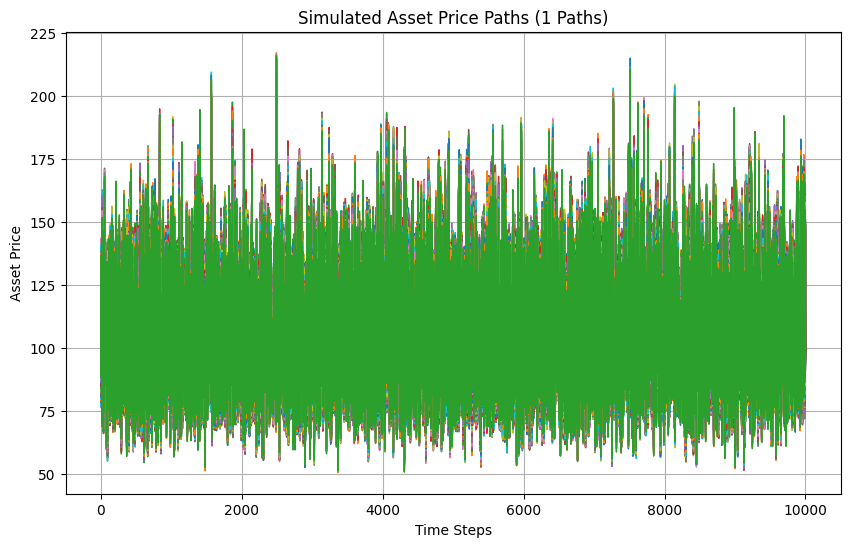

In [8]:
# Example usage for different types of options
s = 100  # Spot price
k = 105  # Strike price
r = 0.05  # Risk-free rate
vol = 0.2  # Volatility
T = 1  # Time to maturity
nb_simul = 10000  # Number of simulations
nb_steps = 252  # Number of time steps (daily)
barrier = 120  # Barrier for barrier option

# Asian option
asian_price, _ = mc_option_pricing('asian', s, r, vol, T, k, nb_simul, nb_steps)
print(f"Asian Option Price: {asian_price:.4f}")

# Barrier option
barrier_price, _ = mc_option_pricing('barrier', s, r, vol, T, k, nb_simul, nb_steps, barrier=barrier)
print(f"Barrier Option Price: {barrier_price:.4f}")

# American option using LSMC
american_price, _ = mc_option_pricing('american', s, r, vol, T, k, nb_simul, nb_steps)
print(f"American Option Price: {american_price:.4f}")

# Plot simulated paths
plt.figure(figsize=(10, 6))
to_plot = 1
for i in range(to_plot):
    print(i)
    plt.plot(_, lw=1)
plt.title(f"Simulated Asset Price Paths ({to_plot} Paths)")
plt.xlabel("Time Steps")
plt.ylabel("Asset Price")
plt.grid(True)
plt.show()

## 6. Conclusion
Monte Carlo methods provide a flexible and powerful approach to pricing exotic options. They simulate many possible future paths of the underlying asset using GBM and compute the average payoff, which is then discounted to the present to estimate the option price. For path-dependent options like Asian and Barrier options, and options with early exercise features like American options, Monte Carlo simulation is often one of the best methods available for accurate pricing.